<a href="https://colab.research.google.com/github/NoahHA/msci-project/blob/master/RNN_multiclass_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loads in the dataframes

In [ ]:
import pandas as pd
import numpy as np
import warnings
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
%matplotlib inline

# loads the dataframes
higgs_df = pd.read_hdf('/content/drive/MyDrive/Colab Notebooks/ttH.hd5')
semi_leptonic_df = pd.read_hdf('/content/drive/MyDrive/Colab Notebooks/ttsemileptonic.hd5')
fully_leptonic_df = pd.read_hdf('/content/drive/MyDrive/Colab Notebooks/fully_leptonic.hd5')
fully_hadronic_df = pd.read_hdf('/content/drive/MyDrive/Colab Notebooks/fully_hadronic.hd5')


# labels signal vs background
higgs_df["signal"] = 0
semi_leptonic_df["signal"] = 1
fully_hadronic_df["signal"] = 2
fully_leptonic_df["signal"] = 3

# combines the dataframes and randomly shuffles the rows
full_df = higgs_df.append(semi_leptonic_df, ignore_index=True)
full_df = full_df.append(fully_leptonic_df, ignore_index=True)
full_df = full_df.append(fully_hadronic_df, ignore_index=True)
full_df = shuffle(full_df)

event_cols = [
    "BiasedDPhi",
    "DiJet_mass",
    "HT",
    "InputMet_InputJet_mindPhi",
    "InputMet_pt",
    "MHT_pt",
    "MinChi",
    "MinOmegaHat",
    "MinOmegaTilde",
    "ncleanedBJet",
    "ncleanedJet",
]

object_cols = [
    "cleanedJet_pt",
    "cleanedJet_area",
    "cleanedJet_btagDeepB",
    "cleanedJet_chHEF",
    "cleanedJet_eta",
    "cleanedJet_mass",
    "cleanedJet_neHEF",
    "cleanedJet_phi",
]

# removes useless columns
df = full_df[event_cols + object_cols + ["signal"]]

# Splits data into event / object dataframes and train / test dataframes

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.preprocessing import sequence

scaler = StandardScaler()

# columns that should not be transformed
untransformed_cols = ["ncleanedBJet", "ncleanedJet", "BiasedDPhi", "signal"]
transformed_cols = list(set(event_cols) - set(untransformed_cols))

# takes the log of each column to remove skewness
for col_name in event_cols:
    if col_name in transformed_cols:
        df[col_name] = np.log(df[col_name])

# splits data into training and validation
num_classes = 4
X, y = df.drop("signal", axis=1), df["signal"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

# divides training data into object level and event level features
event_X_train, event_X_test = X_train[event_cols], X_test[event_cols]
object_X_train, object_X_test = X_train[object_cols], X_test[object_cols]

# scales features so they all have the same mean and variance
event_X_train[event_cols] = scaler.fit_transform(event_X_train[event_cols].values)
event_X_test[event_cols] = scaler.transform(event_X_test[event_cols].values)

max_jets = df["ncleanedJet"].max()

# pads input sequences with zeroes so they're all the same length
for col in object_cols:
    object_X_train[col] = sequence.pad_sequences(
        object_X_train[col].values, padding="post", dtype="float32"
    ).tolist()
    object_X_test[col] = sequence.pad_sequences(
        object_X_test[col].values, padding="post", dtype="float32"
    ).tolist()

print(
    "Removed Columns:",
    [col for col in full_df.columns if col not in set(event_cols + object_cols)],
)
X_train.head()

Removed Columns: ['dataset', 'entry', 'InputMet_phi', 'MHT_phi', 'hashed_filename', 'weight_nominal', 'xs_weight', 'signal']


,BiasedDPhi,DiJet_mass,HT,InputMet_InputJet_mindPhi,InputMet_pt,MHT_pt,MinChi,MinOmegaHat,MinOmegaTilde,ncleanedBJet,ncleanedJet,cleanedJet_pt,cleanedJet_area,cleanedJet_btagDeepB,cleanedJet_chHEF,cleanedJet_eta,cleanedJet_mass,cleanedJet_neHEF,cleanedJet_phi
33877,-2.371782,5.578372,6.191582,-0.100058,5.590054,5.420674,-0.048732,-0.048732,-0.109346,0,5,"[128.97298, 126.03991, 106.90896, 78.90469, 47...","[0.5185547, 0.4387207, 0.47875977, 0.46875, 0....","[0.32910156, 0.027145386, 0.12200928, 0.178710...","[0.41015625, 0.53125, 0.8515625, 0.90625, 0.32...","[1.0888672, 0.51904297, 0.12524414, -0.2700195...","[18.671875, 21.25, 13.1484375, 10.2734375, 6.4...","[0.3046875, 0.078125, 0.060058594, 0.0, 0.0]","[2.6796875, -0.62109375, -0.99902344, -1.91699..."
32313,-2.310997,5.753429,6.323352,-0.683429,5.329695,5.344268,-0.310249,-0.310249,-0.492945,1,6,"[139.75612, 127.27176, 114.92451, 101.942726, ...","[0.5288086, 0.48876953, 0.50878906, 0.50878906...","[0.024368286, 0.07556152, 0.8305664, 0.0189056...","[0.27734375, 0.671875, 0.625, 0.7421875, 0.523...","[-0.6484375, 1.1914062, 2.3085938, 0.8671875, ...","[15.796875, 12.78125, 12.9921875, 9.0703125, 7...","[0.05859375, 0.09667969, 0.0, 0.01171875, 0.02...","[1.1269531, 0.0041542053, -2.4082031, 0.679199..."
307813,-2.056638,4.859487,6.203215,-0.234438,5.394196,5.572961,0.224998,0.080466,-0.309862,1,5,"[139.38309, 138.69556, 116.28844, 68.70731, 31...","[0.48876953, 0.5185547, 0.46875, 0.48876953, 0...","[0.9091797, 0.33935547, 0.13745117, 0.07592773...","[0.859375, 0.8203125, 0.48046875, 0.4609375, 0...","[-0.6098633, -0.0060920715, -0.68066406, 0.101...","[17.90625, 12.0, 21.3125, 8.65625, 5.5117188]","[0.08203125, 0.03564453, 0.02368164, 0.1777343...","[-1.2636719, -1.9746094, 0.08190918, 2.8300781..."
333125,-3.134866,4.821121,5.677958,0.885348,5.471745,5.625339,0.451583,0.098960,-0.251576,0,3,"[139.76898, 80.88621, 71.69655]","[0.48876953, 0.4987793, 0.42895508]","[0.04425049, 0.02407837, 0.008033752]","[0.8125, 0.5546875, 0.6875]","[2.09375, 1.0488281, 1.609375]","[17.015625, 16.578125, 10.03125]","[0.0, 0.03564453, 0.2578125]","[-2.2480469, -2.6601562, -1.7646484]"
109865,-2.933313,6.220085,6.282401,-0.357792,5.398163,5.457184,0.015108,-0.208798,-0.894251,2,5,"[222.48026, 101.46865, 81.508385, 65.58029, 64...","[0.47875977, 0.5683594, 0.5185547, 0.48876953,...","[0.024841309, 0.80566406, 0.013511658, 0.03869...","[0.6953125, 0.546875, 0.7734375, 0.3046875, 0....","[0.02218628, 2.2421875, 1.6611328, -0.3154297,...","[21.546875, 22.125, 10.59375, 10.4453125, 8.69...","[0.1640625, 0.022216797, 0.018066406, 0.0, 0.0]","[-2.4042969, 1.0849609, 2.2988281, -2.9785156,..."


# Expands the lists in the df so they can be used as input

In [ ]:
temp_X_train = np.ndarray(
    shape=(object_X_train.shape[0], max_jets, len(object_X_train.columns))
)
temp_X_test = np.ndarray(
    shape=(object_X_test.shape[0], max_jets, len(object_X_test.columns))
)

# iterate through each column in the df and iterate through each value in the column and then iterate through each item in the list and then put that item in the nparray
for i, col in enumerate(object_cols):
    train_col = object_X_train[col]
    test_col = object_X_test[col]

    for j, event in enumerate(train_col):
        for k, item in enumerate(event):
            temp_X_train[j][k][i] = item

    for j, event in enumerate(test_col):
        for k, item in enumerate(event):
            temp_X_test[j][k][i] = item

object_X_train = temp_X_train
object_X_test = temp_X_test

# turn event_X_train, event_X_test, y_train, and y_test into numpy arrays
event_X_train = event_X_train.to_numpy()
event_X_test = event_X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# one-hot encodes the label data
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# Scales the data

In [ ]:
from sklearn.preprocessing import RobustScaler

nz = np.any(object_X_train, -1)
object_X_train[nz] = RobustScaler().fit_transform(object_X_train[nz])
nz = np.any(object_X_test, -1)
object_X_test[nz] = RobustScaler().fit_transform(object_X_test[nz])

# Oversamples data using SMOTE (optional)

In [ ]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()

# flattens object data
rows = len(object_X_train)
object_X_train = object_X_train.reshape(rows, -1)

y_train2 = y_train.copy()

# oversamples data
event_X_train, y_train = oversample.fit_resample(event_X_train, y_train)
object_X_train, y_train = oversample.fit_resample(object_X_train, y_train2)

# unflattens object data
object_X_train = object_X_train.reshape(len(object_X_train), 14, 8)

# Plots all events in a scatter graph

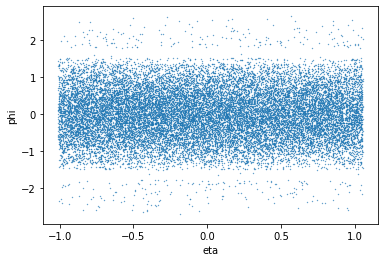

In [ ]:
import matplotlib.pyplot as plt
from numpy.random import randint

plt.scatter(object_X_train[:5000, :, 7], object_X_train[:5000, :, 4], s=0.1) # plots (eta, phi) for all jets
plt.xlabel('eta')
plt.ylabel('phi')
plt.show()

# Saves the preprocessed data

In [ ]:
# object data
np.save('/content/drive/MyDrive/RNN_classifier/object_X_train_multiclass.npy', object_X_train)
np.save('/content/drive/MyDrive/RNN_classifier/object_X_test_multiclass.npy', object_X_test)

# Saves the oversampled preprocessed data (optional)

In [ ]:
# object data
np.save('/content/drive/MyDrive/RNN_classifier/object_X_train_multiclass_smote.npy', object_X_train)
np.save('/content/drive/MyDrive/RNN_classifier/object_X_test_multiclass_smote.npy', object_X_test)